# Clustering

### Cluster Evaluation Metrics

Adjusted Rand Index (ARI) and Adjusted Mutual Information (AMI) are strong metrics for evaluating clustering performance when ground truth labels are available. Both metrics adjust for chance and provide more reliable assessments of clustering accuracy.

Adjusted Rand Index (ARI) measures how similar two clusterings are by considering all pairs of samples and whether they are assigned to the same or different clusters. It is particularly sensitive to the exact cluster assignments and is useful when you want to evaluate how well your clustering aligns with ground truth labels.

Adjusted Mutual Information (AMI) measures the mutual information between two clusterings, normalized to account for randomness. It is more focused on the quality of information shared between the cluster assignments and is less sensitive to differences in cluster sizes.

Since the use case involves well-balanced clusters and want a strict evaluation, ARI is to be prioritized. We can keep AMI as a secondary performance indicator.

### Clustering Approaches

**K-Means Clustering**: As a first attempt, we used the traditional K-Means algorithm. Since the true number of clusters (10) is known, we can directly apply K-Means and analyze its performance.
- Clustering scores are higher with the original dataset compared to data transformed by PCA, NMF, AE, or CAE. However, K-Means with the original data takes significantly more time to execute.
- PCA and CAE embeddings deliver similar performance.
- AE embeddings perform worse than PCA but still yield better results than NMF.
- NMF shows significantly worse performance compared to other approaches.
- Clustering with UMAP-transformed data delivers superior performance compared to other transformations and the original dataset. Interestingly, the number of UMAP components (10, 20, or 80) has little to no effect on the clustering outcomes.
- K-Means does well in a few areas, but in general, the clusters are arbitrarily divided with no clear structure.

**Agglomerative Clustering**: Agglomerative clustering has a time complexity of O(n²), where n is the number of samples. For 60,000 samples, this results in a large memory requirement (~29 GB for the distance matrix), which exceeds the available RAM (8 GB). To address this, we performed clustering on a 10% sample of the dataset.
- Similar to K-Means, clustering with the original dataset scores higher but is slower compared to PCA, NMF, or AE transformations.
- CAE delivers good performance, just under UMAP.
- PCA is better than AE when using Ward to cluster. Surprisingly, AE with 80 dimensions ranks higher than both PCA and the original dataset.
- NMF shows significantly worse performance compared to other approaches.
- Clustering with UMAP-transformed data delivers superior performance compared to other transformations and the original dataset. Interestingly, the number of components (10, 20, or 80) has little to no effect on the clustering outcomes.
- Agglomerative Ward Clustering correctly identifies several clusters and, despite some errors, performs quite well overall.

**HDBSCAN**  (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is an extension of DBSCAN that performs clustering across varying epsilon values and combines the results to improve stability. It is more flexible than DBSCAN and can handle clusters of varying densities. Since HDBSCAN is density-based, the number of clusters cannot be pre-specified. The algorithm requires fine-tuning to match the ground truth clusters, and it is computationally expensive for large datasets. We opted to sample the data to establish a baseline.
- All approaches, except UMAP, perform very poorly. CAE is better than other approaches (except UMAP) but still not very good.
- The clustering scores are higher with the original dataset, compared to data transformed by PCA, NMF, and are comparable to using AE. However, clustering with the original data requires significantly more time to execute.
- PCA and AE have significantly worse performance than other approaches.
- Clustering with UMAP-transformed data delivers superior performance compared to other transformations and the original dataset. Interestingly, the number of components (10, 20, or 80) has little to no effect on the clustering outcomes.
- The baseline HDBSCAN clustering produced four groups, two of which match the ground truth, while the other two are visually coherent but not exactly aligned with the true clusters. Fine-tuning HDBSCAN for a 10-cluster solution is possible but would be computationally expensive.

### Final Recommendation

Agglomerative Clustering with UMAP-transformed data provides the best results, achieving good clustering scores while requiring a manageable computational effort.

### Alternative Approaches

Alternative approachs could involve using the dense mapper from the UMAP package, which better preserves local density, or utilizing a mutual k-NN graph. These methods could enhance the segmentation of similar classes, allowing clustering to generate more accurate results and potentially increase the number of clusters produced by HDBSCAN to align more closely with the ground truth.

Approaches using auto encoders, especially the convolutionnal autoencoder could get better with more advanced and complex networks.

In [1]:
from kagglehub import dataset_download
from tensorflow.keras import datasets as tf_datasets
from pathlib import Path

import pandas as pd 
import numpy as np
import os

from matplotlib import pyplot as plt

from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

2025-02-05 16:12:25.076354: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 16:12:25.342242: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 16:12:25.592712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738768345.835059   95991 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738768345.903078   95991 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 16:12:26.412641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
FASHION_MNIST_HANDLE = 'zalando-research/fashionmnist'

data_location = dataset_download(FASHION_MNIST_HANDLE)
# data_location = '~/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4'

kaggle_data_forlder = Path(data_location)
train_data_filename = 'fashion-mnist_train.csv'

df = pd.read_csv(kaggle_data_forlder / train_data_filename)

X_train, y_train = df.drop(columns='label'), df['label']
(_, tf_y_train), (_, _) = tf_datasets.fashion_mnist.load_data()

custom_normalizer = FunctionTransformer(func=(lambda x: x / 255), inverse_func=(lambda x: (x*255).astype(int)))

X_scaled = custom_normalizer.fit_transform(X_train)

### Useful tools

In [3]:
N_JOBS = os.cpu_count() - 1

In [4]:
DATA_FOLDER = Path('model_selection/data')
MODELS_FOLDER = Path('model_selection/models')
SCORES_FOLDER = Path('model_selection/scores')

if not SCORES_FOLDER.exists(): 
    SCORES_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
X_umap_2 = pd.read_csv(DATA_FOLDER / 'X_umap_2.csv')

In [6]:
def model_evaluate(model, dim_reduction_strat=None, n_components=None, sample_size=None): 
    
    if dim_reduction_strat is None : 
        X = X_scaled
    else : 
        data_path = DATA_FOLDER / f'X_{dim_reduction_strat}_{n_components}.csv'
        X = pd.read_csv(data_path)

    if dim_reduction_strat not in ['ae', 'cae']: 
        y = y_train
    else: 
        y = tf_y_train

    if sample_size is not None: 
        X, _, y, _ = train_test_split(X, y, train_size=sample_size, random_state=42)

    model.fit(X)
    
    scores = {
        'adjusted_rand_score': adjusted_rand_score(model.labels_, y), 
        'adjusted_mutual_info_score': float(adjusted_mutual_info_score(model.labels_, y))
    }

    return scores


## k-means
As a first attempt let’s try the traditional approach: K-Means. In this case we can solve one of the hard problems for K-Means clustering – choosing the right k value, giving the number of clusters we are looking for. In this case we know the answer is exactly 10.

In [7]:
k_means_scores_path = SCORES_FOLDER / 'k_means_scores.csv'

if k_means_scores_path.exists(): 
    k_means_scores_df = pd.read_csv(k_means_scores_path)

else : 
    k_means_scores = []

    ###  Original Data
    k_means_scores.append({
        'dimension_reduction': None,
        'n_components': None,
        **model_evaluate(KMeans(n_clusters=10, random_state=42))
    })

    ### PCA transformed Data
    k_means_scores += [
        {
            'dimension_reduction': 'pca',
            'n_components': 10,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'pca', 10) 
        },
        {
            'dimension_reduction': 'pca',
            'n_components': 20,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'pca', 20) 
        }, 
        {
            'dimension_reduction': 'pca',
            'n_components': 80,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'pca', 80) 
        }, 
    ]

    ### NMF Transformed Data
    k_means_scores += [
        {
            'dimension_reduction': 'nmf',
            'n_components': 10,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'nmf', 10) 
        },
        {
            'dimension_reduction': 'nmf',
            'n_components': 20,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'nmf', 20) 
        }, 
        {
            'dimension_reduction': 'nmf',
            'n_components': 80,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'nmf', 80) 
        }, 
    ]

    ### UMAP Transformed Data
    k_means_scores += [
        {
            'dimension_reduction': 'umap',
            'n_components': 10,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'umap', 10) 
        },
        {
            'dimension_reduction': 'umap',
            'n_components': 20,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'umap', 20) 
        }, 
        {
            'dimension_reduction': 'umap',
            'n_components': 80,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'umap', 80) 
        }, 
    ]

    ### Auto-Encoder Transformed Data
    k_means_scores += [
        {
            'dimension_reduction': 'ae',
            'n_components': 10,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'ae', 10) 
        },
        {
            'dimension_reduction': 'ae',
            'n_components': 20,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'ae', 20) 
        }, 
        {
            'dimension_reduction': 'ae',
            'n_components': 80,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'ae', 80) 
        }, 
    ]
    ### Convolutional Auto-Encoder Transformed Data
    k_means_scores += [
        {
            'dimension_reduction': 'cae',
            'n_components': 10,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'cae', 10) 
        },
        {
            'dimension_reduction': 'cae',
            'n_components': 20,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'cae', 20) 
        }, 
        {
            'dimension_reduction': 'cae',
            'n_components': 80,
            **model_evaluate(KMeans(n_clusters=10, random_state=42), 'cae', 80) 
        }, 
    ]

    k_means_scores_df = pd.DataFrame(k_means_scores)
    k_means_scores_df.to_csv(SCORES_FOLDER / 'k_means_scores.csv', index=False)

k_means_scores_df.sort_values(
    by=['adjusted_rand_score', 'adjusted_mutual_info_score']
    , ascending=[False, False]
)


,dimension_reduction,n_components,adjusted_rand_score,adjusted_mutual_info_score
7,umap,10.0,0.456125,0.622112
9,umap,80.0,0.454360,0.633524
8,umap,20.0,0.454139,0.633707
0,NaN,NaN,0.404701,0.542046
15,cae,80.0,0.395398,0.570130
3,pca,80.0,0.390737,0.523687
13,cae,10.0,0.386969,0.562585
14,cae,20.0,0.364500,0.554621
2,pca,20.0,0.347294,0.507024
1,pca,10.0,0.338712,0.488058


Observations: 
- The clustering scores are higher when using the original dataset compared to data transformed by PCA, NMF, ae or cae. However, clustering with the original data requires significantly more time to execute.
- pca and cae embeedings delivers similar performance.
- ae embeedings have fairly worst results than pca but are better than NMF.
- NMF has significantly worth performance than other approaches.
- Clustering with UMAP-transformed data delivers superior performance compared to other transformations and original dataset. Interestingly, the number of components (10, 20, or 80) has little to no effect on the clustering outcomes.

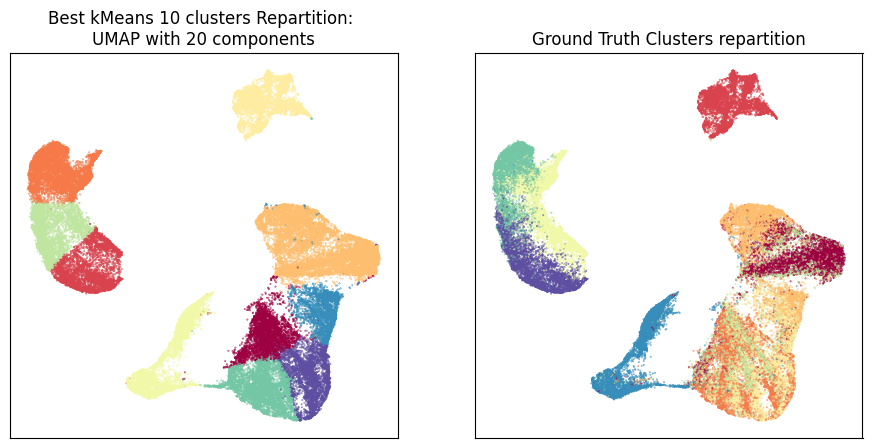

In [8]:
best_kmeans_labels = KMeans(n_clusters=10, random_state=42).fit_predict( pd.read_csv(DATA_FOLDER / 'X_umap_10.csv') )

fig = plt.figure(figsize=(11, 5))
best_kmeans_ax = fig.add_subplot(121)

best_kmeans_ax.scatter(
    X_umap_2['Component_0']
    , X_umap_2['Component_1']
    , c=best_kmeans_labels.astype(np.int32)
    , cmap='Spectral'
    , s=0.1
)
best_kmeans_ax.set_title('Best kMeans 10 clusters Repartition: \nUMAP with 20 components')
best_kmeans_ax.set(xticks=[], yticks=[])

original_ax = fig.add_subplot(122)
original_ax.scatter(
    X_umap_2['Component_0']
    , X_umap_2['Component_1']
    , c=y_train.astype(np.int32)
    , cmap='Spectral'
    , s=0.1
)
original_ax.set_title('Ground Truth Clusters repartition')
original_ax.set(xticks=[], yticks=[])

plt.show()

While K-Means gets some cases correct, such as the cluster on the top right side, most of the rest of the data looks somewhat arbitrarily carved up among the remaining clusters. 

## Agglomerative clustering with Ward

The family of agglomerative clustering algorithms has a time complexity of O(n2)O(n2), where nn is the number of samples. This complexity arises primarily from the memory usage required to compute and store the distance matrix. For 60,000 samples, the distance matrix alone requires approximately 29 GB of RAM, which exceeds the 8 GB available on my machine. To address this limitation, I performed clustering on a sampled dataset consisting of 10% of the original training data.

In [9]:
ward_scores_path = SCORES_FOLDER / 'ward_scores.csv'

if ward_scores_path.exists(): 
    ward_scores_df = pd.read_csv(ward_scores_path)

else : 
    ward_scores = []

    ###  Original Data
    ward_scores.append({
        'dimension_reduction': None,
        'n_components': None,
        **model_evaluate(AgglomerativeClustering(n_clusters=10), sample_size=0.1)
    })

    ### PCA transformed Data
    ward_scores += [
        {
            'dimension_reduction': 'pca',
            'n_components': 10,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'pca', 10, sample_size=0.1) 
        },
        {
            'dimension_reduction': 'pca',
            'n_components': 20,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'pca', 20, sample_size=0.1) 
        }, 
        {
            'dimension_reduction': 'pca',
            'n_components': 80,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'pca', 80, sample_size=0.1) 
        }, 
    ]

    ### NMF Transformed Data
    ward_scores += [
        {
            'dimension_reduction': 'nmf',
            'n_components': 10,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'nmf', 10, sample_size=0.1) 
        },
        {
            'dimension_reduction': 'nmf',
            'n_components': 20,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'nmf', 20, sample_size=0.1) 
        }, 
        {
            'dimension_reduction': 'nmf',
            'n_components': 80,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'nmf', 80, sample_size=0.1) 
        }, 
    ]

    ### UMAP Transformed Data
    ward_scores += [
        {
            'dimension_reduction': 'umap',
            'n_components': 10,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'umap', 10, sample_size=0.1) 
        },
        {
            'dimension_reduction': 'umap',
            'n_components': 20,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'umap', 20, sample_size=0.1) 
        }, 
        {
            'dimension_reduction': 'umap',
            'n_components': 80,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'umap', 80, sample_size=0.1) 
        }, 
    ]

    ### Auto-Encoder Transformed Data
    ward_scores += [
        {
            'dimension_reduction': 'ae',
            'n_components': 10,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'ae', 10, sample_size=0.1) 
        },
        {
            'dimension_reduction': 'ae',
            'n_components': 20,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'ae', 20, sample_size=0.1) 
        }, 
        {
            'dimension_reduction': 'ae',
            'n_components': 80,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'ae', 80, sample_size=0.1) 
        }, 
    ]
    ### Convolutional Auto-Encoder Transformed Data
    ward_scores += [
        {
            'dimension_reduction': 'cae',
            'n_components': 10,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'cae', 10, sample_size=0.1) 
        },
        {
            'dimension_reduction': 'cae',
            'n_components': 20,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'cae', 20, sample_size=0.1) 
        }, 
        {
            'dimension_reduction': 'cae',
            'n_components': 80,
            **model_evaluate(AgglomerativeClustering(n_clusters=10), 'cae', 80, sample_size=0.1) 
        }, 
    ]

    ward_scores_df = pd.DataFrame(ward_scores)
    ward_scores_df.to_csv(ward_scores_path, index=False)

ward_scores_df.sort_values(
    by=['adjusted_rand_score', 'adjusted_mutual_info_score']
    , ascending=[False, False]
)

,dimension_reduction,n_components,adjusted_rand_score,adjusted_mutual_info_score
7,umap,10.0,0.472368,0.656989
8,umap,20.0,0.471000,0.630971
9,umap,80.0,0.433626,0.622254
13,cae,10.0,0.426600,0.592642
14,cae,20.0,0.420423,0.605746
12,ae,80.0,0.380241,0.545681
0,NaN,NaN,0.378539,0.587801
15,cae,80.0,0.373973,0.570800
2,pca,20.0,0.363729,0.537645
3,pca,80.0,0.351579,0.516891


Observations: 
- The clustering scores are higher when using the original dataset compared to data transformed by PCA or NMF or ae. However, clustering with the original data requires significantly more time to execute.
- cae delivers good performance, just under umap
- pca is better than ae when using ward to cluster, suprisingly ae with 80 dimensions ranks higher than pca and base data
- NMF has significantly worth performance than other approaches.
- Clustering with UMAP-transformed data delivers superior performance compared to other transformations and original dataset. Interestingly, the number of components (10, 20, or 80) has little to no effect on the clustering outcomes.

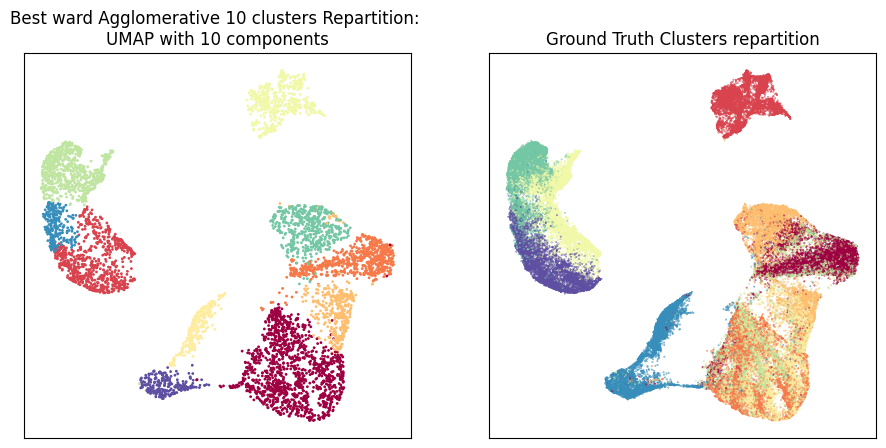

In [10]:
X_sampled, _, y_sampled, _ = train_test_split( pd.read_csv(DATA_FOLDER / 'X_umap_10.csv'), y_train, train_size=0.1, random_state=42 )
X_umap_2_sampled, _ = train_test_split(X_umap_2, train_size=0.1, random_state=42)

best_ward = AgglomerativeClustering(n_clusters=10)
best_ward.fit( X_sampled )

fig = plt.figure(figsize=(11, 5))
best_ward_ax = fig.add_subplot(121)

best_ward_ax.scatter(
    X_umap_2_sampled['Component_0']
    , X_umap_2_sampled['Component_1']
    , c=best_ward.labels_.astype(np.int32)
    , cmap='Spectral'
    , s=1
)
best_ward_ax.set_title('Best ward Agglomerative 10 clusters Repartition: \nUMAP with 10 components')
best_ward_ax.set(xticks=[], yticks=[])

original_ax = fig.add_subplot(122)
original_ax.scatter(
    X_umap_2['Component_0']
    , X_umap_2['Component_1']
    , c=y_train.astype(np.int32)
    , cmap='Spectral'
    , s=0.1
)
original_ax.set_title('Ground Truth Clusters repartition')
original_ax.set(xticks=[], yticks=[])

plt.show()

Agglomerative Ward Clustering correctly identifies several clusters and, despite some errors, performs quite well overall.

## HDBSCAN

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) extends DBSCAN by performing clustering across varying epsilon values and combining the results to achieve optimal stability. This approach enables HDBSCAN to identify clusters of varying densities, making it more flexible than DBSCAN and less sensitive to parameter selection.

However, since HDBSCAN is density-based, the number of clusters cannot be specified beforehand. Instead, the algorithm must be fine-tuned to produce a clustering outcome close to the ground truth. Given that HDBSCAN can be computationally intensive, particularly for large datasets, I opted to sample the data initially to establish a baseline.

In [11]:
baseline_hdbscan_scores_path = SCORES_FOLDER / 'baseline_hdbscan_scores.csv'

if baseline_hdbscan_scores_path.exists(): 
    baseline_hdbscan_scores_df = pd.read_csv(baseline_hdbscan_scores_path)

else : 
    baseline_hdbscan_scores = []

    ###  Original Data
    baseline_hdbscan_scores.append({
        'dimension_reduction': None,
        'n_components': None,
        **model_evaluate(HDBSCAN(n_jobs=N_JOBS), sample_size=0.1)
    })

    ### PCA transformed Data
    baseline_hdbscan_scores += [
        {
            'dimension_reduction': 'pca',
            'n_components': 10,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'pca', 10, sample_size=0.1) 
        },
        {
            'dimension_reduction': 'pca',
            'n_components': 20,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'pca', 20, sample_size=0.1) 
        }, 
        {
            'dimension_reduction': 'pca',
            'n_components': 80,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'pca', 80, sample_size=0.1) 
        }, 
    ]

    ### NMF Transformed Data
    baseline_hdbscan_scores += [
        {
            'dimension_reduction': 'nmf',
            'n_components': 10,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'nmf', 10, sample_size=0.1) 
        },
        {
            'dimension_reduction': 'nmf',
            'n_components': 20,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'nmf', 20, sample_size=0.1) 
        }, 
        {
            'dimension_reduction': 'nmf',
            'n_components': 80,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'nmf', 80, sample_size=0.1) 
        }, 
    ]

    ### UMAP Transformed Data
    baseline_hdbscan_scores += [
        {
            'dimension_reduction': 'umap',
            'n_components': 10,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'umap', 10, sample_size=0.1) 
        },
        {
            'dimension_reduction': 'umap',
            'n_components': 20,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'umap', 20, sample_size=0.1) 
        }, 
        {
            'dimension_reduction': 'umap',
            'n_components': 80,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'umap', 80, sample_size=0.1) 
        }, 
    ]

    ### Auto-Encoder Transformed Data
    baseline_hdbscan_scores += [
        {
            'dimension_reduction': 'ae',
            'n_components': 10,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'ae', 10, sample_size=0.1) 
        },
        {
            'dimension_reduction': 'ae',
            'n_components': 20,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'ae', 20, sample_size=0.1) 
        }, 
        {
            'dimension_reduction': 'ae',
            'n_components': 80,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'ae', 80, sample_size=0.1) 
        }, 
    ]
    ### Convolutional Auto-Encoder Transformed Data
    baseline_hdbscan_scores += [
        {
            'dimension_reduction': 'cae',
            'n_components': 10,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'cae', 10, sample_size=0.1) 
        },
        {
            'dimension_reduction': 'cae',
            'n_components': 20,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'cae', 20, sample_size=0.1) 
        }, 
        {
            'dimension_reduction': 'cae',
            'n_components': 80,
            **model_evaluate(HDBSCAN(n_jobs=N_JOBS), 'cae', 80, sample_size=0.1) 
        }, 
    ]

    baseline_hdbscan_scores_df = pd.DataFrame(baseline_hdbscan_scores)
    baseline_hdbscan_scores_df.to_csv(baseline_hdbscan_scores_path, index=False)

baseline_hdbscan_scores_df.sort_values(
    by=['adjusted_rand_score', 'adjusted_mutual_info_score']
    , ascending=[False, False]
)

,dimension_reduction,n_components,adjusted_rand_score,adjusted_mutual_info_score
8,umap,20.0,0.297362,0.615279
9,umap,80.0,0.297342,0.614638
7,umap,10.0,0.297293,0.615377
13,cae,10.0,0.163063,0.399031
15,cae,80.0,0.151880,0.326022
14,cae,20.0,0.151005,0.327555
6,nmf,80.0,0.077794,0.214393
10,ae,10.0,0.046316,0.304774
0,NaN,NaN,0.043650,0.113009
5,nmf,20.0,0.034714,0.274219


Observations: 
- All approaches, except UMAP, perform very poorly. cae is better than other approaches (except umap) but still not very good.
- The clustering scores are higher when using the original dataset compared to data transformed by PCA or NMF and comparable to using ae. However, clustering with the original data requires significantly more time to execute.
- PCA and ae have significantly worth performance than other approaches.
- Clustering with UMAP-transformed data delivers superior performance compared to other transformations and original dataset. Interestingly, the number of components (10, 20, or 80) has little to no effect on the clustering outcomes.

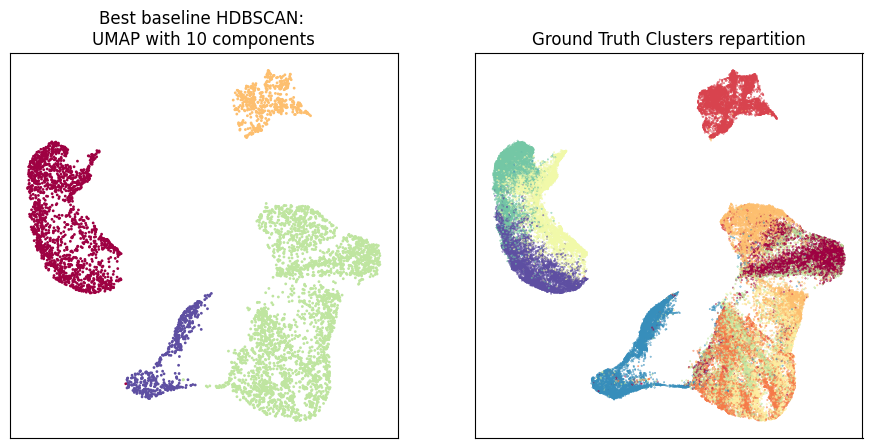

In [12]:
X_sampled, _, y_sampled, _ = train_test_split( pd.read_csv(DATA_FOLDER / 'X_umap_10.csv'), y_train, train_size=0.1, random_state=42 )
X_umap_2_sampled, _ = train_test_split(X_umap_2, train_size=0.1, random_state=42)

best_baseline_hdbscan = HDBSCAN(n_jobs=N_JOBS)
best_baseline_hdbscan.fit( X_sampled )

fig = plt.figure(figsize=(11, 5))
best_baseline_hdbscan_ax = fig.add_subplot(121)

best_baseline_hdbscan_ax.scatter(
    X_umap_2_sampled['Component_0']
    , X_umap_2_sampled['Component_1']
    , c=best_baseline_hdbscan.labels_.astype(np.int32)
    , cmap='Spectral'
    , s=1
)
best_baseline_hdbscan_ax.set_title('Best baseline HDBSCAN: \nUMAP with 10 components')
best_baseline_hdbscan_ax.set(xticks=[], yticks=[])

original_ax = fig.add_subplot(122)
original_ax.scatter(
    X_umap_2['Component_0']
    , X_umap_2['Component_1']
    , c=y_train.astype(np.int32)
    , cmap='Spectral'
    , s=0.1
)
original_ax.set_title('Ground Truth Clusters repartition')
original_ax.set(xticks=[], yticks=[])

plt.show()

The baseline HDBSCAN clusters the data into four groups, two of which match the ground truth, while the remaining two are visually coherent. Fine-tuning HDBSCAN to achieve a 10-cluster solution is a possibility, but it would be computationally expensive.

An alternative approach could involve using the dense mapper from the UMAP package, which better preserves local density, or utilizing a mutual k-NN graph. These methods could enhance the segmentation of similar classes, allowing HDBSCAN to generate more accurate results and potentially increase the number of clusters to align more closely with the ground truth.

## Scores Comparison

In [13]:
k_means_scores_df['model'] = 'k-means'
ward_scores_df['model'] = 'ward'
baseline_hdbscan_scores_df['model'] = 'hdbscan'

recap_df = pd.concat(
    [k_means_scores_df, ward_scores_df, baseline_hdbscan_scores_df]
    , ignore_index=True
).sort_values(
    by=['adjusted_rand_score', 'adjusted_mutual_info_score']
    , ascending=[False, False]
).reset_index(
    drop=True
)
recap_df[['model'] + list(recap_df.columns[:-1])]

,model,dimension_reduction,n_components,adjusted_rand_score,adjusted_mutual_info_score
0,ward,umap,10.0,0.472368,0.656989
1,ward,umap,20.0,0.471000,0.630971
2,k-means,umap,10.0,0.456125,0.622112
3,k-means,umap,80.0,0.454360,0.633524
4,k-means,umap,20.0,0.454139,0.633707
5,ward,umap,80.0,0.433626,0.622254
6,ward,cae,10.0,0.426600,0.592642
7,ward,cae,20.0,0.420423,0.605746
8,k-means,NaN,NaN,0.404701,0.542046
9,k-means,cae,80.0,0.395398,0.570130
